In [1]:
import gym
import numpy as np
from gym import error, spaces, utils, Env
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

/opt/anaconda3/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


# Descripción del problema

El siguiente ejemplo consiste en un Ambiente (Room). La temperatura de la habitación cambia debido a la temperatura externa ambiente (se asume de forma desconocida). La habitación cuenta con un equipo de Aire Acondicionado controlado por un Agente. El objetivo de este Agente es mantener la temperatura en 0 grados. El Aire Acondicionado puede cambiar la temperatura en 0, 1, 2 o 3 grados ya sea frío o calor.

# Ambiente

El ambiente (Room) está simulado por el siguiente código

In [82]:
class Room(Env):
    
    def __init__(self):
        self.observation_space = spaces.Box(low=-20, high=40, shape=(), dtype=np.float32)
        self.action_space = spaces.Discrete(7, start=-3)
                  
    def reset(self):
        self.step_count = 0
        self.initial_random = self.observation_space.sample()
        self.external_temp = 0
        self.external_temp = self._temp_variation()
        self.temp = self.external_temp
        return self.temp
    
    def nonRandomReset(self, initialTemp, externalTemp):
        self.step_count = 0
        self.initial_random = initialTemp
        self.external_temp = 0
        self.external_temp = externalTemp
        self.temp = self.external_temp
        return self.temp
    
    def step(self, action):
        delta_temp = self._temp_variation()
        self.external_temp += delta_temp
        self.temp += delta_temp + action
        self.step_count += 1
        return self.temp

    def _temp_variation(self):
        x = self.initial_random + self.step_count
        return np.float64('%.2f'%(20 * np.sin(x/10))) - self.external_temp 
          

# Reflex Agente

Esta es la implementación de un Agente Reflejo Simple, que dada la observación (temperatura de la habitación), toma una acción de enfriar o calentar en 0, 1, 2 o 3 grados. El agente solo enfría o calienta si la temperatura difiere en más de 2 grados.

In [8]:
class AgentReflex():

    def lookup(self, obs):
        if obs > 9:
            return -3
        elif obs > 5:
            return -2
        elif obs > 2:
            return -1
        elif obs < -2:
            return 1
        elif obs < -5:
            return 2
        elif obs < -9:
            return 3
        else:
            return 0
    def get_action(self, obs, goal):
        difference = obs - goal
        if difference > 3:
            return -3
        elif difference > 2:
            return -2
        elif difference > 1:
            return -1
        elif difference < -3:
            return 3
        elif difference < -2:
            return 2
        elif difference < -1:
            return 1
        else:
            return 0

# Test Reflex

In [10]:
env = Room()
agent = AgentReflex()

In [13]:
obs = env.reset()
external_res = []
agent_res = []
total_steps = 120
target = 0

In [14]:
for i in range(0, total_steps):  
    
    # solamente para evaluar la evolución de la temperatura de la habitación con y sin agente
    # la temperatura de la habitación sin el agente es igual a la temperatura exterior
    
    external_temp = env.external_temp
    external_res.append(external_temp)
    
    # decisión y acción del agente
    
    prev_obs = obs
    action = agent.get_action(obs, target)
    obs = env.step(action)
    agent_res.append(obs)  
    
    print('External:', external_temp, '\n','Prev. Obs:', prev_obs, '-> Action:', action, '-> Room:', obs)

External: 2.78 
 Prev. Obs: 2.78 -> Action: -2 -> Room: 0.7799999999999998
External: 2.78 
 Prev. Obs: 0.7799999999999998 -> Action: 0 -> Room: 2.75
External: 4.75 
 Prev. Obs: 2.75 -> Action: -2 -> Room: 2.66
External: 6.66 
 Prev. Obs: 2.66 -> Action: -2 -> Room: 2.51
External: 8.51 
 Prev. Obs: 2.51 -> Action: -2 -> Room: 2.2799999999999994
External: 10.28 
 Prev. Obs: 2.2799999999999994 -> Action: -2 -> Room: 1.9399999999999995
External: 11.94 
 Prev. Obs: 1.9399999999999995 -> Action: -1 -> Room: 2.4800000000000004
External: 13.48 
 Prev. Obs: 2.4800000000000004 -> Action: -2 -> Room: 1.8900000000000006
External: 14.89 
 Prev. Obs: 1.8900000000000006 -> Action: -1 -> Room: 2.1499999999999986
External: 16.15 
 Prev. Obs: 2.1499999999999986 -> Action: -2 -> Room: 1.2399999999999984
External: 17.24 
 Prev. Obs: 1.2399999999999984 -> Action: -1 -> Room: 1.1700000000000017
External: 18.17 
 Prev. Obs: 1.1700000000000017 -> Action: -1 -> Room: 0.9100000000000001
External: 18.91 
 Prev. 

# Graficando los resultados

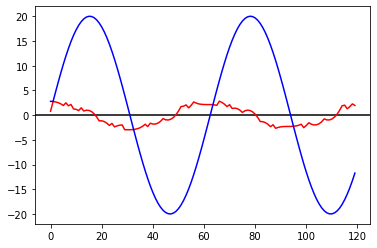

In [15]:
plt.axhline(color='black')                                  #Temperatura ideal
plt.plot(range(0, total_steps), agent_res, color='red')     #Temperatura con el agente
plt.plot(range(0, total_steps), external_res, color='blue') #Temperatura sin agente

# Métrica de Performance
Una posible métrica de performance, podría ser ver la temperatura media del ambiente con la acción del agente.

In [17]:
print("Temperatura media con el agente: ", np.mean(agent_res))
print("Temperatura media sin el agente: ", np.mean(external_res))

Temperatura media con el agente:  -0.15391666666666662
Temperatura media sin el agente:  0.28633333333333355


Otra posible métrica de performance, es evaluar para cada instante de tiempo (step) cuanto difiere la temperatura obtenida de la objetivo=0. Esto se puede hacer con mean_squared_error o mean_absolute_error. 
Comparemos la métrica obtenida por el agente contra la métrica obtenida sin un agente:

In [16]:
goal_temp = np.zeros(total_steps)
print("Variación media con el agente: ", mean_absolute_error(goal_temp, agent_res))
print("Variación media sin el agente: ", mean_absolute_error(goal_temp, external_res))

Variación media con el agente:  1.7027499999999998
Variación media sin el agente:  13.079666666666666


# Ejercicio: Model (Goal / Utility) Based Agent 

Construir un Agente basado en un modelo. 
Esto es: 
    - Construir un modelo a mano, por ejemplo un grafo, con estados y transiciones [Ver figura].
    - Discretizar las observaciones devueltas por el ambiente mapeándolas a un estado.
    - Tomar una decisón basada en el estado.
    - Definir un objetivo y una utilidad

Por ejemplo, el Agente podría conocer un modelo que tiene 2 estados {Frío, Calor}
<img src="Modelo.png">


### Agente Model

In [137]:
class AgentModel():
    def __init__(self):
        self.prev_obs = 0
        self.prev_action = 0
        self.estado = ""

    def get_estado(self):
        return self.estado

    def get_actionWithObs(self, obs, goal):
        delta_temp = obs - (self.prev_obs + self.prev_action)
        difference = (obs - goal) + delta_temp
        action = 0
        
        # if difference > 3:
        #     action = -3
        # elif difference > 2:
        #     action = -2
        # elif difference > 1:
        #     action = -1
        # elif difference < -3:
        #     action = 3
        # elif difference < -2:
        #     action = 2
        # elif difference < -1:
        #     action = 1
        # else:
        #     action = 0
            
        if difference >= 3:
            action = -3
        elif difference >= 2:
            action = -2
        elif difference >= 1/2:
            action = -1
        elif difference <= -3:
            action = 3
        elif difference <= -2:
            action = 2
        elif difference <= -1/2:
            action = 1
        else:
            action = 0
            
            
        self.prev_obs = obs
        self.prev_action = action
        return action

    def get_actionWithoutObs(self, obs, goal):
        delta_temp = obs - (self.prev_obs + self.prev_action)
        difference = delta_temp

        if difference > 3:
            action = -3
        elif difference > 2:
            action = -2
        elif difference > 1:
            action = -1
        elif difference < -3:
            action = 3
        elif difference < -2:
            action = 2
        elif difference < -1:
            action = 1
        else:
            action = 0
            
        self.prev_obs = obs
        self.prev_action = action
        return action


In [138]:
env_Obs = Room()
env_NonObs = Room()
agent = AgentModel()

env_Obs.seed(42)
env_NonObs.seed(42)
obs_Obs = env_Obs.nonRandomReset(-10,-10)
obs_NonObs = env_NonObs.nonRandomReset(-10,-10)

agent_Obs_res = []
external_res_Obs = []
agent_NonObs_res = []
external_res_NonObs = []

total_steps = 500
target = 0

#WithObs
for i in range(0, total_steps):  
    
    # solamente para evaluar la evolución de la temperatura de la habitación con y sin agente
    # la temperatura de la habitación sin el agente es igual a la temperatura exterior
    
    external_temp_Obs = env_Obs.external_temp
    external_res_Obs.append(external_temp_Obs)
    
    external_temp_NonObs = env_NonObs.external_temp
    external_res_NonObs.append(external_temp_NonObs)
    
    # decisión y acción del agente
    
    prev_obs_Obs = obs_Obs
    action_Obs = agent.get_actionWithObs(obs_Obs, target)
    obs_Obs = env_Obs.step(action_Obs)
    agent_Obs_res.append(obs_Obs)  
    
    prev_obs_NonObs = obs_NonObs
    action_NonObs = agent.get_actionWithoutObs(obs_NonObs, target)
    obs_NonObs = env_NonObs.step(action_NonObs)
    agent_NonObs_res.append(obs_NonObs)  
    
    print('[ WithObs  ] External:', external_temp_Obs,'Prev. Obs:', prev_obs_Obs, '-> Action:', action_Obs, '-> Room:', obs_Obs)
    print('[WithoutObs] External:', external_temp_NonObs,'Prev. Obs:', prev_obs_NonObs, '-> Action:', action_NonObs, '-> Room:', obs_NonObs)
 
    


/opt/anaconda3/lib/python3.9/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


[ WithObs  ] External: -10 Prev. Obs: -10 -> Action: 3 -> Room: -13.829999999999998
[WithoutObs] External: -10 Prev. Obs: -10 -> Action: 2 -> Room: -14.829999999999998
[ WithObs  ] External: -16.83 Prev. Obs: -13.829999999999998 -> Action: 3 -> Room: -9.67
[WithoutObs] External: -16.83 Prev. Obs: -14.829999999999998 -> Action: 3 -> Room: -10.67
[ WithObs  ] External: -15.67 Prev. Obs: -9.67 -> Action: 3 -> Room: -5.35
[WithoutObs] External: -15.67 Prev. Obs: -10.67 -> Action: 3 -> Room: -6.35
[ WithObs  ] External: -14.35 Prev. Obs: -5.35 -> Action: 3 -> Room: -0.8800000000000008
[WithoutObs] External: -14.35 Prev. Obs: -6.35 -> Action: 3 -> Room: -1.8800000000000008
[ WithObs  ] External: -12.88 Prev. Obs: -0.8800000000000008 -> Action: -1 -> Room: -0.28999999999999915
[WithoutObs] External: -12.88 Prev. Obs: -1.8800000000000008 -> Action: 0 -> Room: -0.28999999999999915
[ WithObs  ] External: -11.29 Prev. Obs: -0.28999999999999915 -> Action: -1 -> Room: 0.41000000000000014
[WithoutOb

### Metricas Agent Model

Variación media con el agente con Obs:  1.25048
Variación media sin el agente:  12.68256
Variación media con el agente sin Obs:  2.1338000000000004
Variación media sin el agente:  12.68256


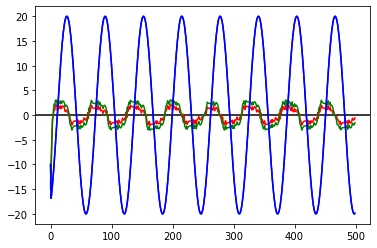

In [139]:
goal_temp = np.zeros(total_steps)
print("Variación media con el agente con Obs: ", mean_absolute_error(goal_temp, agent_Obs_res))
print("Variación media sin el agente: ", mean_absolute_error(goal_temp, external_res_Obs))
print("Variación media con el agente sin Obs: ", mean_absolute_error(goal_temp, agent_NonObs_res))
print("Variación media sin el agente: ", mean_absolute_error(goal_temp, external_res_NonObs))


plt.axhline(color='black')                                        #Temperatura ideal
plt.plot(range(0, total_steps), agent_Obs_res, color='red')       #Temperatura con el agente con Obs
plt.plot(range(0, total_steps), agent_NonObs_res, color='green')  #Temperatura con el agente sin Obs
plt.plot(range(0, total_steps), external_res_NonObs, color='blue')       #Temperatura sin agente
plt.plot(range(0, total_steps), external_res_Obs, color='blue')   